### CH4/03 Using geospatial data with shapely
main > Ch04 > 04_03 > geo.py

# Geographic Data Analysis with Shapely, Pandas, and Folium

This script demonstrates how to:
- Work with geometric points and polygons using Shapely.
- Process GPS tracking data with Pandas.
- Visualize spatial relationships using Folium maps.

## Dependencies
Ensure you have the following libraries installed:
- `shapely` for geometric operations.
- `pandas` for handling and processing data.
- `numpy` for numerical operations.
- `folium` for map visualization.

## Code Breakdown

### 1. Creating a Point
A point is instantiated using Shapely.

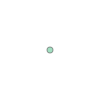

In [7]:
from shapely.geometry import Point

pt = Point(1, 2)
pt

### 2. Accessing Point Coordinates
The .x and .y attributes retrieve the point's coordinates.

In [10]:
pt.x, pt.y

(1.0, 2.0)

### 3. Defining a Polygon
A polygon is created from a set of coordinate points.

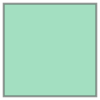

In [13]:
from shapely.geometry import Polygon

poly = Polygon([
    [0, 0], [0, 10], [10, 10], [10, 0]
])
poly


### 4. Computing Area and Centroid
Shapely provides utilities to calculate area and centroid.

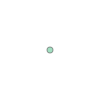

In [16]:
poly.area
poly.centroid


### 5. Checking Point-Polygon Intersection
Determines whether a point lies within the polygon.

In [19]:
poly.intersects(pt)
poly.intersects(Point(10, 20))


False

### 6. Loading and Resampling GPS Data
Reads and resamples a dataset to get minute-level averages.

In [22]:
import pandas as pd

df = pd.read_csv(
    'track.csv',
    parse_dates=['time'],
    index_col='time',
)
df = df.resample('min').mean()


In [24]:
df.head(5)

,lat,lng,height
time,,,
2015-08-20 03:48:00,32.519485,35.014571,122.766666
2015-08-20 03:49:00,32.518971,35.014316,122.966667
2015-08-20 03:50:00,32.517258,35.014055,114.573913
2015-08-20 03:51:00,32.516264,35.013864,106.653334
2015-08-20 03:52:00,32.515141,35.012744,97.710000


### 7. Converting Dataframe to Shapely Points
Each row's latitude and longitude are converted into a Point.

In [27]:
df['point'] = df[['lat', 'lng']].apply(Point, axis=1)
df.head()


,lat,lng,height,point
time,,,,
2015-08-20 03:48:00,32.519485,35.014571,122.766666,POINT (32.51948457142857 35.01457057142857)
2015-08-20 03:49:00,32.518971,35.014316,122.966667,POINT (32.51897133333333 35.01431633333333)
2015-08-20 03:50:00,32.517258,35.014055,114.573913,POINT (32.517257826086954 35.0140552173913)
2015-08-20 03:51:00,32.516264,35.013864,106.653334,POINT (32.5162645 35.01386383333333)
2015-08-20 03:52:00,32.515141,35.012744,97.710000,POINT (32.51514063333333 35.012744399999995)


### 8. Defining a Polygon Based on Data
Constructs a polygon using mean and max latitude/longitude.

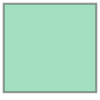

In [30]:
mid_lat, max_lat = df['lat'].mean(), df['lat'].max()
mid_lng, max_lng = df['lng'].mean(), df['lng'].max()
poly = Polygon([
    [mid_lat, mid_lng], [mid_lat, max_lng],
    [max_lat, max_lng], [max_lat, mid_lng]
])
poly


### 9. Filtering Points Inside the Polygon
Extracts rows where the GPS point intersects the polygon.

In [33]:
df[df['point'].apply(poly.intersects)]


,lat,lng,height,point
time,,,,
2015-08-20 04:15:00,32.512503,35.017157,96.547368,POINT (32.51250347368421 35.0171572631579)
2015-08-20 04:16:00,32.513188,35.017025,105.791305,POINT (32.51318756521739 35.017025347826085)
2015-08-20 04:17:00,32.513920,35.016963,113.803846,POINT (32.51392023076923 35.016963076923076)
2015-08-20 04:18:00,32.514767,35.016075,116.869231,POINT (32.51476676923077 35.01607546153846)
2015-08-20 04:19:00,32.516021,35.015776,115.725000,POINT (32.516021464285714 35.01577553571428)


### 10. Extracting Polygon Boundary Coordinates
Obtains exterior coordinates for visualization.

In [36]:
poly.exterior.xy


(array('d', [32.5123189947394, 32.5123189947394, 32.51948457142857, 32.51948457142857, 32.5123189947394]),
 array('d', [35.01567806812501, 35.02252776190476, 35.02252776190476, 35.01567806812501, 35.01567806812501]))

### 11. Stacking and Transposing Coordinates
Formats polygon boundary points for use with Folium.

In [39]:
import numpy as np

points = np.stack(poly.exterior.xy).T


## 12. Visualizing the Polygon with Folium
Creates a map centered on the mean location and adds the polygon.

In [42]:
import folium

m = folium.Map(
    location=[df['lat'].mean(), df['lng'].mean()],
    zoom_start=15,
)
m.add_child(folium.PolyLine(points))
m


### 13. Mapping GPS Points and Polygon Interaction
Adds markers indicating whether each point is inside the polygon.

In [45]:
center = [df['lat'].mean(), df['lng'].mean()]
m = folium.Map(location=center, zoom_start=15)
m.add_child(folium.PolyLine(points))

def add_marker(row):
    loc = tuple(row[['lat', 'lng']])
    in_poly = poly.intersects(row['point'])
    marker = folium.CircleMarker(
        loc, radius=5, color='yellow' if in_poly else 'green',
        popup=row.name.strftime('%H:%M'),
    )
    marker.add_to(m)

df.apply(add_marker, axis=1)
m


### 14. Saving the Map as an HTML File

In [ ]:
m.save('CH4_03_Using_geospatial_data_with_shapely.html')

- **`m.save`**: Saves the generated map object `m` to an HTML file named `CH4_03_Using_geospatial_data_with_shapely.html`. This file can be opened in a web browser to view the interactive map.

---